<a href="https://colab.research.google.com/github/Sa234557/Youtube-Video-Chaptering-Project/blob/main/YoutubeVideoChaptering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
pip install youtube-transcript-api

In [45]:
import youtube_transcript_api

In [46]:
import re
import csv
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

# Load the SpaCy English model
nlp = spacy.load('en_core_web_sm')

API_KEY = 'your_api_key'

def get_video_id(url: str) -> str:
    """Extracts video ID from a YouTube URL."""
    video_id_match = re.search(r'(?:v=|\/)([0-9A-Za-z_-]{11}).*', url)
    return video_id_match.group(1) if video_id_match else None

def get_video_title(video_id: str) -> str:
    """Fetches the title of the YouTube video."""
    youtube = build('youtube', 'v3', developerKey=API_KEY)
    request = youtube.videos().list(part='snippet', id=video_id)
    response = request.execute()
    return response['items'][0]['snippet']['title'] if response['items'] else 'Unknown Title'

def get_video_transcript(video_id: str) -> list:
    """Fetches the transcript of the YouTube video."""
    try:
        return YouTubeTranscriptApi.get_transcript(video_id)
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

def save_to_csv(title: str, transcript: list, filename: str):
    """Saves the video title and transcript to a CSV file."""
    transcript_data = [{'start': entry['start'], 'text': entry['text']} for entry in transcript]
    df = pd.DataFrame(transcript_data)
    df.to_csv(filename, index=False)
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Title:', title])

def clean_text(text: str) -> str:
    """Cleans the text using SpaCy."""
    doc = nlp(text)
    custom_stop_words = {'okay', 'we will see', 'um', 'uh', 'like', 'you know'}
    filtered_tokens = [
        token.text for token in doc
        if not token.is_stop and not token.is_punct and token.text.lower() not in custom_stop_words
    ]
    return ' '.join(filtered_tokens)

def analyze_transcript(transcript_df: pd.DataFrame):
    """Analyzes the transcript to identify topics and chapter breaks."""
    transcript_df['start'] = pd.to_numeric(transcript_df['start'], errors='coerce')

    # Clean the text
    transcript_df['cleaned_text'] = transcript_df['text'].apply(clean_text)

    # Topic modeling using NMF
    vectorizer = CountVectorizer(stop_words='english')
    tf = vectorizer.fit_transform(transcript_df['cleaned_text'])

    n_topics = 10
    nmf = NMF(n_components=n_topics, random_state=42).fit(tf)
    tf_feature_names = vectorizer.get_feature_names_out()

    def display_topics(model, feature_names, no_top_words):
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
            topics.append(" ".join(topic_words))
        return topics

    topics = display_topics(nmf, tf_feature_names, 10)
    print("\nIdentified Topics:")
    for i, topic in enumerate(topics):
        print(f"Topic {i + 1}: {topic}")



def main():
    url = input('Enter the YouTube video link: ')
    video_id = get_video_id(url)

    if not video_id:
        print('Invalid YouTube URL.')
        return

    title = get_video_title(video_id)
    transcript = get_video_transcript(video_id)

    if not transcript:
        print('No transcript available for this video.')
        return

    filename = f"{video_id}_transcript.csv"
    save_to_csv(title, transcript, filename)
    print(f'Transcript saved to {filename}')

    # Load the transcript for analysis
    transcript_df = pd.read_csv(filename)
    analyze_transcript(transcript_df)

if __name__ == '__main__':
    main()

Enter the YouTube video link: https://www.youtube.com/watch?v=Yxt72aDjFgY
Transcript saved to Yxt72aDjFgY_transcript.csv

Identified Topics:
Topic 1: solar panels panel multiple module generate powered controller vast time
Topic 2: light electricity produce means garden produced brighter faster voltage eye
Topic 3: electrons holes free flow region flowing exist large form add
Topic 4: silicon pure atoms layer use rods raw atom electricity shell
Topic 5: energy large waves low generated rays gamma excess sun wavelength
Topic 6: cell connected photons modules typically 72 60 use called 96
Topic 7: power grid led use batteries excess connect night time home
Topic 8: electron hole need layer flow volts knock attracted free leaving
Topic 9: cells voltage connected modules use adds connect series 60 terminals
Topic 10: battery charge charging charges controller need going use works dc


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# load the dataset
transcript_df = pd.read_csv("/content/Yxt72aDjFgY_transcript.csv")
print(transcript_df.head())

   start                                     text
0   0.32   why are there crystals here but not on
1   2.76  this one and how does solar panels even
2   5.44    work let's find out you can now buy a
3   7.72     mug and a hoodie to help support the
4  9.599    channel links down below solar panels


In [58]:
transcript_df['start'] = pd.to_numeric(transcript_df['start'], errors='coerce')

print("Dataset Overview:")
print(transcript_df.info())
print("\nBasic Statistics:")
print(transcript_df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   507 non-null    float64
 1   text    508 non-null    object 
dtypes: float64(1), object(1)
memory usage: 8.1+ KB
None

Basic Statistics:
             start
count   507.000000
mean    682.173702
std     389.130806
min       0.320000
25%     345.620000
50%     687.560000
75%    1012.700000
max    1345.440000


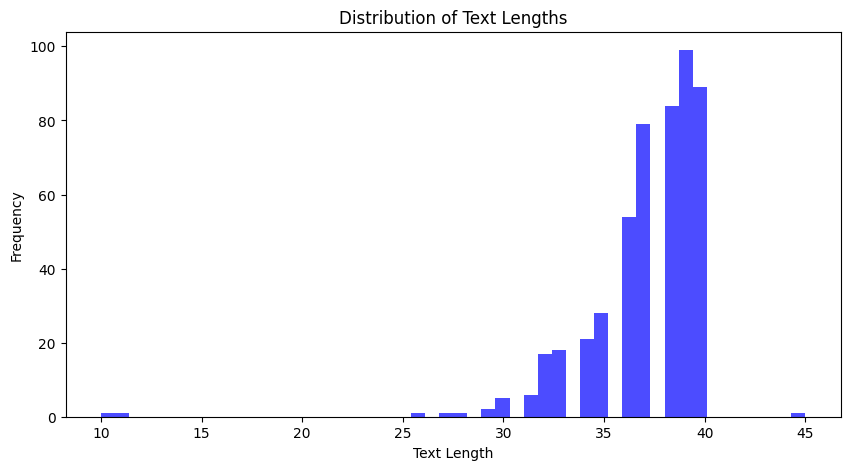

In [59]:
transcript_df['text_length'] = transcript_df['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(transcript_df['text_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


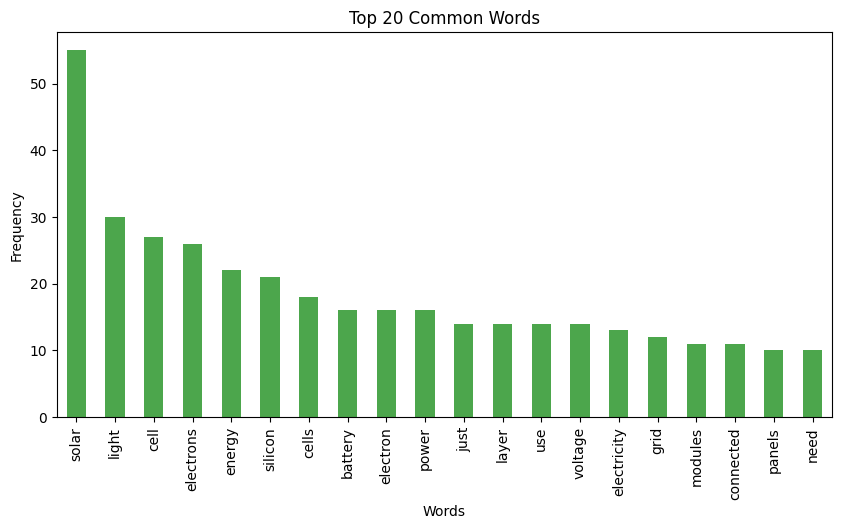

In [60]:
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(transcript_df['text'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts_df.sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 5))
common_words.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top 20 Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [61]:
n_features = 1000
n_topics = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(transcript_df['text'])
nmf = NMF(n_components=n_topics, random_state=42).fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

topics = display_topics(nmf, tf_feature_names, n_top_words)
print("\nIdentified Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i + 1}: {topic}")


Identified Topics:
Topic 1: solar panels panel module generate powered make multiple controller vast
Topic 2: light electricity produce garden means produced voltage eye material produces
Topic 3: electrons holes free flow region flowing exist large add form
Topic 4: silicon pure atoms layer use rods atom raw electricity shell
Topic 5: energy large waves generated low excess sun wavelength reflected junction
Topic 6: cell connected photons modules use typically 72 60 called absorbs
Topic 7: power grid led use batteries excess night connect time leds
Topic 8: electron hole need layer flow volts knock attracted free leaving
Topic 9: cells just connected modules voltage multiple use connect adds volts
Topic 10: battery charge controller charges charging need use inverter going dc


In [62]:
topic_distribution = nmf.transform(tf)

# align the lengths by trimming the extra row in topic_distribution
topic_distribution_trimmed = topic_distribution[:len(transcript_df)]

# compute the dominant topic for each text segment
transcript_df['dominant_topic'] = topic_distribution_trimmed.argmax(axis=1)

In [63]:
# analyze the content of each text segment to manually identify logical breaks
logical_breaks = []

for i in range(1, len(transcript_df)):
    if transcript_df['dominant_topic'].iloc[i] != transcript_df['dominant_topic'].iloc[i - 1]:
        logical_breaks.append(transcript_df['start'].iloc[i])

In [64]:
# consolidate the logical breaks into broader chapters
threshold = 60  # seconds
consolidated_breaks = []
last_break = None

for break_point in logical_breaks:
    if last_break is None or break_point - last_break >= threshold:
        consolidated_breaks.append(break_point)
        last_break = break_point

In [65]:
final_chapters = []
last_chapter = (consolidated_breaks[0], transcript_df['dominant_topic'][0])

for break_point in consolidated_breaks[1:]:
    current_topic = transcript_df[transcript_df['start'] == break_point]['dominant_topic'].values[0]
    if current_topic == last_chapter[1]:
        last_chapter = (last_chapter[0], current_topic)
    else:
        final_chapters.append(last_chapter)
        last_chapter = (break_point, current_topic)

final_chapters.append(last_chapter)

In [66]:
chapter_points = []
chapter_names = []

for i, (break_point, topic_idx) in enumerate(final_chapters):
    chapter_time = pd.to_datetime(break_point, unit='s').strftime('%H:%M:%S')
    chapter_points.append(chapter_time)

    # get the context for the chapter name
    chapter_text = transcript_df[(transcript_df['start'] >= break_point) & (transcript_df['dominant_topic'] == topic_idx)]['text'].str.cat(sep=' ')

    # extract key phrases to create a chapter name
    vectorizer = TfidfVectorizer(stop_words='english', max_features=3)
    tfidf_matrix = vectorizer.fit_transform([chapter_text])
    feature_names = vectorizer.get_feature_names_out()
    chapter_name = " ".join(feature_names)

    chapter_names.append(f"Chapter {i+1}: {chapter_name}")

# display the final chapter points with names
print("\nFinal Chapter Points with Names:")
for time, name in zip(chapter_points, chapter_names):
    print(f"{time} - {name}")


Final Chapter Points with Names:
00:00:02 - Chapter 1: cells solar voltage
00:01:04 - Chapter 2: electron hole layer
00:02:05 - Chapter 3: cells solar voltage
00:03:07 - Chapter 4: electrons free holes
00:04:07 - Chapter 5: cells modules voltage
00:05:07 - Chapter 6: panel panels solar
00:06:13 - Chapter 7: grid power use
00:07:16 - Chapter 8: electricity light produce
00:09:20 - Chapter 9: ac inverter learn
00:10:20 - Chapter 10: electricity light produce
00:11:22 - Chapter 11: energy sun wavelength
00:12:23 - Chapter 12: cells solar used
00:13:25 - Chapter 13: energy wavelength waves
00:14:25 - Chapter 14: light produce solar
00:15:27 - Chapter 15: atoms shell silicon
00:16:30 - Chapter 16: energy nanom wavelength
00:17:31 - Chapter 17: atoms outermost shell
00:18:33 - Chapter 18: 10 engineering positive
00:19:38 - Chapter 19: atoms outermost shell
00:20:40 - Chapter 20: dc depletion electricity
00:21:41 - Chapter 21: break electrons ends
